# Julia Agent Based Simulations 

This notebook has mainly been implemented following the Agents.jl official documentation tutorials [[1](https://juliadynamics.github.io/Agents.jl/dev/examples/sir/#), [2](https://juliadynamics.github.io/Agents.jl/dev/examples/social_distancing/#)].

## SIR Epidemic Modelling

Julia implementation of the SIR model. Additional details about this type of model are available in the [Epidemic Modelling Case Study](http://3.22.240.181:8501/) web app. An SIR model, is an epidemic model used to track the number of individuals susceptible, infected and recovered from a desease. In order to make this model more realistic, aadditional categories can be added such as a portion of individual infected but not tested and people which might be re-infected after recovering. Finally, a mortality rate is added in order to further divide the recovered compartment.

In [22]:
using Agents, Random, DataFrames, LightGraphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using Plots
using LinearAlgebra: diagind
using AgentsPlots

In this section, helper functions are created in order to instantiate the agents composing the population and their initial parameters.

In [23]:
mutable struct Individual <: AbstractAgent
    id::Int
    pos::Int
    days_infected::Int
    status::Symbol  # 1: S, 2: I, 3:R
end

function model_initiation(;
    Ns, migration_rates,
    β_und, β_det,
    infection_period, reinfection_probability,
    detection_time, death_rate,
    Is
)

    C = length(Ns)
    # Normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end

    properties = @dict(
        Ns, Is,
        β_und, β_det, 
        migration_rates, 
        infection_period, infection_period,
        reinfection_probability, detection_time,
        C, death_rate
    )
    space = GraphSpace(complete_digraph(C))
    model = ABM(Individual, space; properties = properties)

    # Add initial individuals
    for city in 1:C, n in 1:Ns[city]
        ind = add_agent!(city, model, 0, :S) # Susceptible
    end
    # Add infected individuals
    for city in 1:C
        inds = get_node_contents(city, model)
        for n in 1:Is[city]
            agent = model[inds[n]]
            agent.status = :I # Infected
            agent.days_infected = 1
        end
    end
    return model
end

function create_params(;
    C, max_travel_rate,
    infection_period, reinfection_probability,
    detection_time, death_rate,
    Is = [zeros(Int, C - 1)..., 1]
)

    Ns = rand(50:5000, C)
    β_und = rand(0.3:0.02:0.6, C)
    β_det = β_und ./ 10

    migration_rates = zeros(C, C)
    for c in 1:C
        for c2 in 1:C
            migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
        end
    end
    maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
    migration_rates[diagind(migration_rates)] .= 1.0

    params = @dict(
        Ns, 
        β_und, β_det,
        migration_rates,
        infection_period, reinfection_probability,
        detection_time, death_rate,
        Is
    )

    return params
end

create_params (generic function with 1 method)

In this section insead, are definied the building blocks of our SIR model.

In [24]:
function agent_step!(agent, model)
    migrate!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
end

function migrate!(agent, model)
    nodeid = agent.pos
    d = DiscreteNonParametric(1:(model.C), model.migration_rates[nodeid, :])
    m = rand(d)
    if m ≠ nodeid
        move_agent!(agent, m, model)
    end
end

function transmit!(agent, model)
    agent.status == :S && return
    rate = if agent.days_infected < model.detection_time
        model.β_und[agent.pos]
    else
        model.β_det[agent.pos]
    end

    d = Poisson(rate)
    n = rand(d)
    n == 0 && return

    for contactID in get_node_contents(agent, model)
        contact = model[contactID]
        if contact.status == :S ||
           (contact.status == :R && rand() ≤ model.reinfection_probability)
            contact.status = :I
            n -= 1
            n == 0 && return
        end
    end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
    if agent.days_infected ≥ model.infection_period
        if rand() ≤ model.death_rate
            kill_agent!(agent, model)
        else
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

recover_or_die! (generic function with 1 method)

We are now ready to run our model and store all the necessary metrics for later analysis.

In [10]:
susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

params = create_params(C=12, max_travel_rate = 0.07,     
                       infection_period = 14, reinfection_probability = 0.04,
                       detection_time = 5, death_rate = 0.15)
model = model_initiation(; params...)

to_collect = [(:status, f) for f in (susceptible, infected, recovered, length)]
data, _ = run!(model, agent_step!, 100; adata = to_collect)
data[1:10, :]

,step,susceptible_status,infected_status,recovered_status,length_status
,Int64,Int64,Int64,Int64,Int64
1,0,30089,1,0,30090
2,1,30089,1,0,30090
3,2,30084,6,0,30090
4,3,30080,10,0,30090
5,4,30075,15,0,30090
6,5,30067,23,0,30090
7,6,30047,43,0,30090
8,7,30002,88,0,30090
9,8,29941,149,0,30090


### SIR Model TIme Evolution

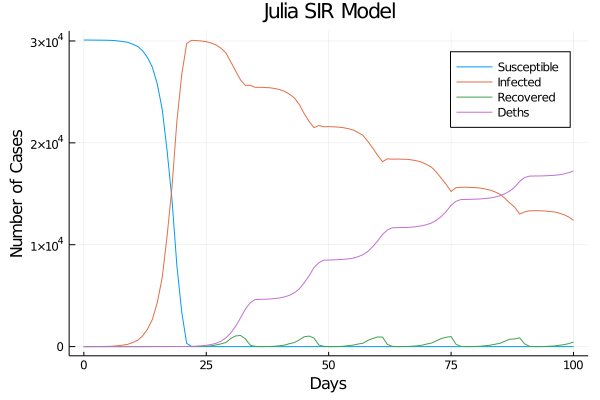

In [11]:
N = sum(model.Ns) # Total initial population
x = data.step
p = plot(
    x,
    data[:, aggname(:status, susceptible)],
    label = "Susceptible",
    xlabel = "Days",
    ylabel = "Number of Cases",
    title = "Julia SIR Model"
)
plot!(p, x, data[:, aggname(:status, infected)], label = "Infected")
plot!(p, x, data[:, aggname(:status, recovered)], label = "Recovered")
dead = N .- data[:, aggname(:status, length)]
plot!(p, x, dead, label = "Deths")

### SIR Model Graph Space

This type of graph can be used in order to quickly inspect how a desease can spread from one community to another depending on the connection strenghts between the different cities. Later on, we will instead look at how a desease can quickly spread within a community.

┌ Info: Saved animation to 
│   fn = C:\Users\hp\Dropbox\Research Project\Dashboard\Epidemics-Modelling\notebooks\SIR_network.gif
└ @ Plots C:\Users\hp\.julia\packages\Plots\JKY3H\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\hp\\Dropbox\\Research Project\\Dashboard\\Epidemics-Modelling\\notebooks\\SIR_network.gif")
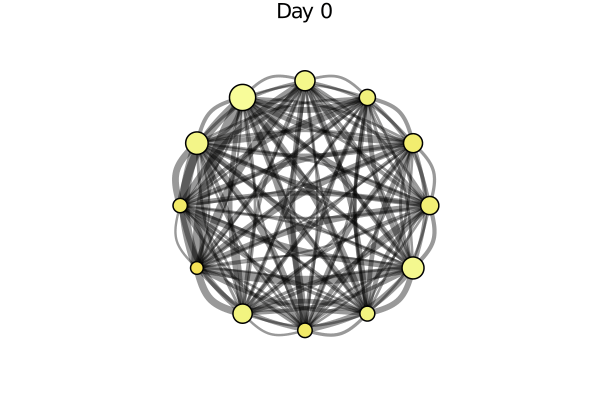

In [12]:
g = model.space.graph
edgewidthsdict = Dict()
for node in 1:nv(g)
    nbs = neighbors(g, node)
    for nb in nbs
        edgewidthsdict[(node, nb)] = params[:migration_rates][node, nb]
    end
end

edgewidthsf(s, d, w) = edgewidthsdict[(s, d)] * 250

plotargs = (node_size = 0.2, method = :circular, linealpha = 0.4)

plotargs = merge(plotargs, (edgewidth = edgewidthsf,))

infected_fraction(x) = cgrad(:inferno)[count(a.status == :I for a in x) / length(x)]

anim = @animate for i in 0:30
    i > 0 && step!(model, agent_step!, 1)
    p1 = plotabm(model; ac = infected_fraction, plotargs...)
    title!(p1, "Day $(i)")
end

gif(anim, "SIR_network.gif", fps = 5)